This is my very first Kaggle competition! I'm excited and I picked a pretty basic one - **categorize forest cover type** based on ~50 features. Looks like a job for a decision tree. I've never used one before, so I'll be learning here!

In [25]:
import pandas as pd
from sklearn import tree
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

The training data is ~5MB so I can easily load it into memory. Yay!

In [26]:
df = pd.read_csv("../data/train.csv").drop('Id', axis=1)

In [27]:
print df.shape

(15120, 55)


In [28]:
print df.dropna().shape

(15120, 55)


No NaNs at all!? Thanks forest service!

I'm going to run this right out of the box, per SKLearn's excellent documentation.

###For now, I like the random forest method the best. Now I'll take a look at other ways to optimize my score.

##Feature engineering:
I haven't looked at the features yet. It appears that if I want to get up in the ranks, I will have to take the gloves off and think about what's going on a little more deeply.

I will start by plotting a frequency distribution of the features.

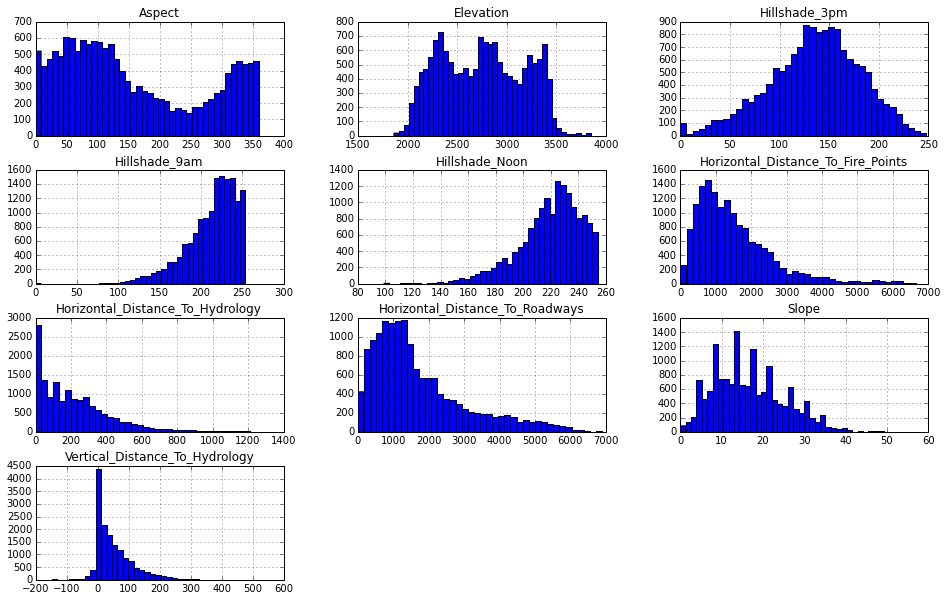

In [29]:
df.ix[:,0:10].hist(figsize=(16,10),bins=40)
plt.show()

So there are a ton of soil types and a few wilderness areas, but I think it would be easier to look at the first 10 columns.

The first thing that jumps out at me is the aspect, or the azimuthal angle. Since the sun passes from east to west, these values should be symmetric, so I believe we should be looking at the **distance from 180 degrees**.

In [30]:
def t_aspect(x):
    if x>180:
        return x-180
    else:
        return x
    
df['Aspect'] = df.Aspect.map(t_aspect)

Another thing that looks weird is the appearance of negative values in the 'vertical distance to hydrology' category. I believe this indicates that some samples are elevated above a water source. I have read that including a dummy variable that indicates whether this value is positive or negative may help with a decision tree (which is likly what I'll be using).

In [31]:
df['below_water'] = df.Vertical_Distance_To_Hydrology > 0

I would also like to see an overall distance feature.

In [32]:
df['hydro_distance'] = (df['Horizontal_Distance_To_Hydrology']**2 + df['Vertical_Distance_To_Hydrology']**2)**0.5

I should also make some combinations of these distance parameters. While I don't think they should be correlated, a decision tree will be much better at finding a relationship than I would be.

In [33]:
df['water_fire'] = (df['Horizontal_Distance_To_Hydrology']**2 + df['Horizontal_Distance_To_Fire_Points']**2)**0.5
df['water_road'] = (df['Horizontal_Distance_To_Hydrology']**2 + df['Horizontal_Distance_To_Roadways']**2)**0.5
df['fire_road'] = (df['Horizontal_Distance_To_Fire_Points']**2 + df['Horizontal_Distance_To_Roadways']**2)**0.5

###Out of the box decision tree:

In [34]:
clf = tree.DecisionTreeClassifier()
Y = df['Cover_Type']
X = df.drop('Cover_Type', axis=1)
clf.fit(X,Y)

DecisionTreeClassifier(compute_importances=None, criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_density=None, min_samples_leaf=1, min_samples_split=2,
            random_state=None, splitter='best')

In [12]:
print df[df['Cover_Type'] == 1].shape

(2160, 57)


Cool, it ran the decision tree. But I have no idea what the decision surface looks like. I don't even know what the important features are. Let's take a look at a Principal Component Analysis on the data:

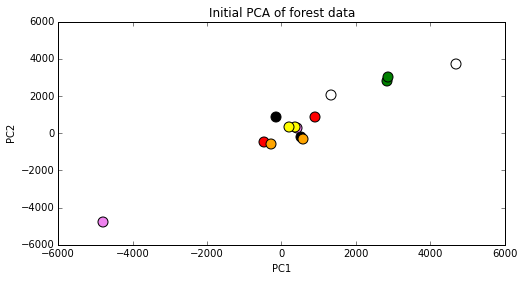

In [13]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
xy = dict()
for i in range(1,8):
    temp = df[df['Cover_Type'] == i].drop('Cover_Type', axis=1)
    xy[str(i)] = pca.fit(temp).transform(temp)


l = {'1':'white', '2':'green', '3':'black', '4':'red', '5':'violet', '6':'orange', '7':'yellow'}

fig = plt.figure(figsize=(8,4))
for i in xy:
    plt.scatter(xy[i][0], xy[i][1], label='test', c=l[i], s=100)

plt.title('Initial PCA of forest data')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

This looks very clustered and, if we were drawing a decision boundary in the PC space, it would be very difficult to get decent separation between some of the categories. But of course I haven't done any cross-validation, so I'm going to do that now.

I will iterate through a range of k-fold cross validations and see which one allows my current decision tree to best fit the cross-validation data. This will take a while to run.

In [35]:
import time
def feature_eng(df):
    def t_aspect(x):
        if x>180:
            return x-180
        else:
            return x
    
    df['Aspect'] = df.Aspect.map(t_aspect)
    df['below_water'] = df.Vertical_Distance_To_Hydrology > 0
    df['hydro_distance'] = (df['Horizontal_Distance_To_Hydrology']**2 + df['Vertical_Distance_To_Hydrology']**2)**0.5
    df['water_fire'] = (df['Horizontal_Distance_To_Hydrology']**2 + df['Horizontal_Distance_To_Fire_Points']**2)**0.5
    df['water_road'] = (df['Horizontal_Distance_To_Hydrology']**2 + df['Horizontal_Distance_To_Roadways']**2)**0.5
    df['fire_road'] = (df['Horizontal_Distance_To_Fire_Points']**2 + df['Horizontal_Distance_To_Roadways']**2)**0.5
    return df


def optimize_k(folds, model, _x_, _y_):
    scores = []
    std = []
    index = []
    start = time.clock()
    for i in range(2, folds):
        kf = KFold(len(_y_), n_folds = i, shuffle=True)
        _scores = []
        for train_index, test_index in kf:
            x_train, x_test = _x_[train_index], _x_[test_index]
            y_train, y_test = _y_[train_index], _y_[test_index]
            clf = model
            clf.fit(x_train, y_train)
            ypred = clf.predict(x_test)
            #_scores.append(accuracy_score(y_test, ypred))
            _scores.append( (ypred != y_test).mean())
        scores.append(np.mean(np.array(_scores)))
        #std.append(np.std(np.array(_scores)))
        index.append(i)
    #plt.errorbar(index, scores, std, marker='^')
    plt.plot(index, scores)
    plt.ylabel('Error rate')
    plt.xlabel('Folds')
    print 'Executed in ' + str(time.clock()-start) + 's'
    plt.show()
    
def test_model(folds, model, _x_, _y_, sub):
    #Home
    path = "../../../../../WorkLocal/Kaggle/forest_2015/"
    #Work
    #path = "../../../../../WorkLocal/Kaggle/kaggle/forest_2015/data/"
    start = time.clock()
    df_test = pd.read_csv(path + "test.csv")
    df_test = feature_eng(df_test)
    test_X = df_test.drop('Id', axis=1)
    indices = df_test['Id']
    ypred = []

    kf = KFold(len(_y_), n_folds = folds, shuffle=True)
    _scores = []
    for train_index, test_index in kf:
        x_train, x_test = kx[train_index], kx[test_index]
        y_train, y_test = ky[train_index], ky[test_index]
        clf = model
        clf.fit(x_train, y_train)
        ypred.append(clf.predict(test_X))
    
    Ypred = np.array(ypred).mean(0)
    Ypred = np.around(Ypred)
    Ypred = Ypred.astype(int)
    export = pd.Series(Ypred, name='Cover_Type', index=indices)
    export.index.name = 'Id'
    export.to_csv(path + 'submission_'+str(sub)+'.csv', header=True, index=True)
    print "Prediction written to 'submission_"+str(sub)+".csv'"
    print 'Executed in ' + str(time.clock()-start) + 's'
    

##Testing multiclass classification models:

In [36]:
from sklearn.cross_validation import KFold
from sklearn.metrics import accuracy_score
import time
kx = np.array(X)
ky = np.array(Y)

###Decision tree:

Executed in 45.920958s


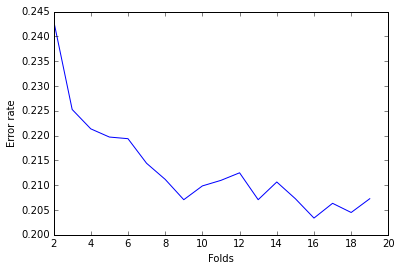

In [16]:
optimize_k(20, tree.DecisionTreeClassifier(), kx, ky)

It looks like after about 12 folds in the training data, cross-validation performance starts to level off. That's good because more folds means more computing time. Unfortunately, this is only at about 80% description of the variance, which is not good enough, since the current leader has a 100% fit.

Since this is my first competition, I will take this model and submit it to see what happens. I don't expect to get very far on the leader board, but it would be personal validation to not be the worst submission.

The test data is much larger (~76MB) than the training data, but still small enough to fit into memory. I expect this will take a while, but I'll give it a shot anyway.

In [37]:
test_model(10, tree.DecisionTreeClassifier(), kx, ky, 1)

Prediction written to 'submission_1.csv'
Executed in 28.78807s


Sweet! I am currently the **1106th best entry** (out of 1341). That's not so great, but hey it's my first one. My model only explained **60%** of the variation, so let's see what more I can do beyond using a default decision tree/k-fold CV methodology.

###Random forest:
(The default is 10 classifiers)

Executed in 65.982433s


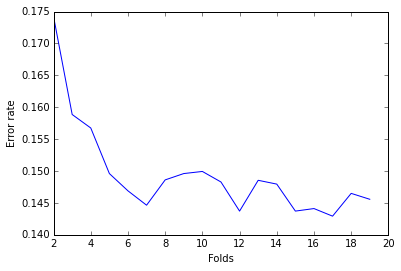

In [39]:
from sklearn.ensemble import RandomForestClassifier
optimize_k(20, RandomForestClassifier(), kx, ky)

This is much faster and looks to be a slightly better method with K again being optimized around 12 (with asymptotically better prediction coming at higher K).

Let's try optimizing the number of classifiers in the random forest:

In [40]:
scores = []
index = []
start = time.clock()
for i in range(1,50):
    kf = KFold(len(ky), n_folds = 12, shuffle=True)
    _scores = []
    for train_index, test_index in kf:
        x_train, x_test = kx[train_index], kx[test_index]
        y_train, y_test = ky[train_index], ky[test_index]
        clf = RandomForestClassifier(n_estimators=i)
        clf.fit(x_train, y_train)
        ypred = clf.predict(x_test)
        _scores.append( (ypred != y_test).mean())
    scores.append(np.mean(np.array(_scores)))
    index.append(i)
plt.plot(index, scores)
plt.title('Error rate vs number of random forest classifiers')
print 'Executed in ' + str(time.clock()-start) + 's'
plt.show()

KeyboardInterrupt: 

This is again asymptotic, but I'd say 22 looks like a good number of classifiers. Let's try running the test set against this model.

In [ ]:
test_model(12, RandomForestClassifier(n_estimators=22), kx, ky, 2)

My score bumped up to **0.700** and I am now ranked **980 out of 1361**. Still not great, but I'm getting better!

###Feature standardization:
One thing I didn't do was standardize my data. This is a very quick process, but I'm not sure how much it would affect this process. I guess there's one way to find out!

In [41]:
from sklearn import preprocessing

kx = preprocessing.scale(np.array(X))

/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:332: UserWarning: The scale function assumes floating point values as input, got object
  "got %s" % (estimator, X.dtype))


AttributeError: 'float' object has no attribute 'sqrt'

In [42]:
optimize_k(25, RandomForestClassifier(n_estimators=22), kx, ky)

KeyboardInterrupt: 

This didn't appear to help very much (if at all). I'm going to play around a bit more with the random forest module, since the only parameter I was optimizing was the number of estimators.

###Back to random forests...

I will start by looking at the maximum depth of the tree. We may want there to be a restriction on this, as very deep trees can instigate overfitting. But we also don't want to sacrifice performance with our cross-validation data.

In [ ]:
scores = []
index = []
start = time.clock()
for i in range(1,30):
    kf = KFold(len(ky), n_folds = 12, shuffle=True)
    _scores = []
    for train_index, test_index in kf:
        x_train, x_test = kx[train_index], kx[test_index]
        y_train, y_test = ky[train_index], ky[test_index]
        clf = RandomForestClassifier(n_estimators=22, max_depth=i)
        clf.fit(x_train, y_train)
        ypred = clf.predict(x_test)
        _scores.append( (ypred != y_test).mean())
    scores.append(np.mean(np.array(_scores)))
    index.append(i)
plt.plot(index, scores)
plt.title('Error rate vs number of random forest classifiers')
print 'Executed in ' + str(time.clock()-start) + 's'
plt.show()

It looks like trees deeper than ~22 units provide no benefit. I'll cut off my trees there.

Now I will look at the **minimum number of samples required to split a node into new leaves**:

In [ ]:
scores = []
index = []
start = time.clock()
for i in range(1,10):
    kf = KFold(len(ky), n_folds = 12, shuffle=True)
    _scores = []
    for train_index, test_index in kf:
        x_train, x_test = kx[train_index], kx[test_index]
        y_train, y_test = ky[train_index], ky[test_index]
        clf = RandomForestClassifier(n_estimators=22, max_depth=22, min_samples_split=i)
        clf.fit(x_train, y_train)
        ypred = clf.predict(x_test)
        _scores.append( (ypred != y_test).mean())
    scores.append(np.mean(np.array(_scores)))
    index.append(i)
plt.plot(index, scores)
plt.title('Error rate vs number of random forest classifiers')
print 'Executed in ' + str(time.clock()-start) + 's'
plt.show()

Looks like the default of 2 is good. A slightly larger 3 might be better here because it is a steeper restriction and doesn't hurt the error rate.

Now I'll look at the **minimum number of samples for newly created leaves**. A split will only happen if the new leaves contain at least this many samples.

In [ ]:
scores = []
index = []
start = time.clock()
for i in range(1,10):
    kf = KFold(len(ky), n_folds = 12, shuffle=True)
    _scores = []
    for train_index, test_index in kf:
        x_train, x_test = kx[train_index], kx[test_index]
        y_train, y_test = ky[train_index], ky[test_index]
        clf = RandomForestClassifier(n_estimators=22, max_depth=22, min_samples_split=3, min_samples_leaf=i)
        clf.fit(x_train, y_train)
        ypred = clf.predict(x_test)
        _scores.append( (ypred != y_test).mean())
    scores.append(np.mean(np.array(_scores)))
    index.append(i)
plt.plot(index, scores)
plt.title('Error rate vs number of random forest classifiers')
print 'Executed in ' + str(time.clock()-start) + 's'
plt.show()

Any increase in this number hurts the error rate a lot so I'll leave it at the default value of 1.

Okay, I've tinkered with the model a bit. It doesn't look like the error rate is being helped by this, but we don't care too much about the training error rate - what matters is what happens with the test data.

In [ ]:
test_model(12, RandomForestClassifier(n_estimators=22, max_depth=22, min_samples_split=3), kx, ky, 3)

This all **dropped my score to 0.687**. So this appears to not be a great way to go.

After taking a look in the Kaggle forum, I noticed people are using 100-500 estimators. It appears I may be analyzing the wrong order of magnitude in terms of estimators. I will write a new function to look at 10, 100, and 1000 estimators.

Executed in 283.613127s


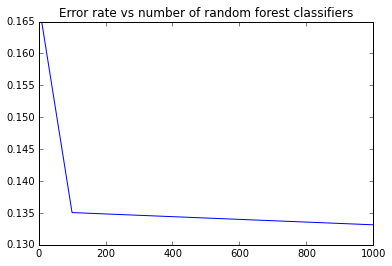

In [20]:
scores = []
index = []
start = time.clock()
for i in [10,100,1000]:
    kf = KFold(len(ky), n_folds = 10, shuffle=True)
    _scores = []
    for train_index, test_index in kf:
        x_train, x_test = kx[train_index], kx[test_index]
        y_train, y_test = ky[train_index], ky[test_index]
        clf = RandomForestClassifier(n_estimators=i)
        clf.fit(x_train, y_train)
        ypred = clf.predict(x_test)
        _scores.append( (ypred != y_test).mean())
    scores.append(np.mean(np.array(_scores)))
    index.append(i)
plt.plot(index, scores)
plt.title('Error rate vs number of random forest classifiers')
print 'Executed in ' + str(time.clock()-start) + 's'
plt.show()

Wow! That definitely improves the error rate by a significant quantity. I think a few hundred classifiers is all I need here.

In [21]:
test_model(12, RandomForestClassifier(n_estimators=500), kx, ky, 4)

Prediction written to 'submission_4.csv'
Executed in 895.734628s


This improved my score to 0.734, which was not quite as much as I was expecting, but good nonetheless.

Just because I'm running out of ides, I'll try a **ExtraTreesClassifier**.

Executed in 333.99137s


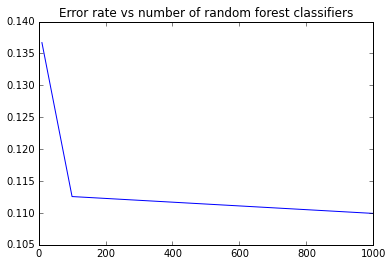

In [43]:
from sklearn.ensemble import ExtraTreesClassifier
scores = []
index = []
start = time.clock()
for i in [10,100,1000]:
    kf = KFold(len(ky), n_folds = 10, shuffle=True)
    _scores = []
    for train_index, test_index in kf:
        x_train, x_test = kx[train_index], kx[test_index]
        y_train, y_test = ky[train_index], ky[test_index]
        clf = ExtraTreesClassifier(n_estimators=i)
        clf.fit(x_train, y_train)
        ypred = clf.predict(x_test)
        _scores.append( (ypred != y_test).mean())
    scores.append(np.mean(np.array(_scores)))
    index.append(i)
plt.plot(index, scores)
plt.title('Error rate vs number of random forest classifiers')
print 'Executed in ' + str(time.clock()-start) + 's'
plt.show()

This looks *slightly* better. The slope is also looking steeper at the end and the 1000 classifiers might be worthwhile.

In [44]:
test_model(10, ExtraTreesClassifier(n_estimators=1500), kx, ky, 4)

Prediction written to 'submission_4.csv'
Executed in 2341.726007s


This bumped me up to **0.738**, so not much. To get any better, I think I will have to revisit the feature engineering aspect of this analysis.

##Feature engineering part 2:

This notebook is a bit out of order now, as I just added the combined distance metrics seen at the front of the notebook and reran the previous model. My score was bumped up to **0.769**, which puts me in **322nd place**. Now I'm really getting somewhere. As of now, this puts me in the top 25% of my first competition, which is very exciting. But I still want to get a bit higher.

If the combined distance metrics improved my score so much, it may be worth exploring other variables that are correlated and creating combinations of those. Furthermore, I haven't touched the 40 soil type dummy columns and I think there may be a way to group those.